In [122]:
import pandas as pd
import numpy as np
import scipy

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

from PyDictionary import PyDictionary
import json
import bs4
import copy

# Corpus of Late Modern English (CLMET 3.1)

## Data Pre-Processing (Parsing, Word Segmentation, Removal of Stopwords)

In [ ]:
#parsing CLMET data, and store data in pandas DataFrame

dataDir = '/Users/lingdai/Downloads/clmet/corpus/txt/plain/'

CLMET3DF = pandas.DataFrame()

DocDict = {"id":[],
           "file":[],
           "period":[],
           "quartcent":[],
           "decade":[],
           "year":[],
           "genre":[],
           "subgenre":[],
           "title":[],
           "author":[],
           "gender":[],
           "text":[]}

for Doc in ((dataDir + file) for file in os.listdir(dataDir) if file.endswith(".txt")):
    file = open(Doc, "r")
    soup = bs4.BeautifulSoup(file.read(), "html.parser")
    DocDict['id'].append(soup.find("id").text)
    DocDict['file'].append(soup.find("file").text)
    DocDict['period'].append(soup.find("period").text) #file_name
    DocDict['quartcent'].append(soup.find("quartcent").text) #file_name
    DocDict['decade'].append(soup.find("decade").text) #file_name
    DocDict['year'].append(soup.find("year").text) #file_name
    DocDict['genre'].append(soup.find("genre").text) #file_name
    DocDict['subgenre'].append(soup.find("subgenre").text) #file_name
    DocDict['title'].append(soup.find("title").text) #file_name
    DocDict['author'].append(soup.find("author").text) #file_name
    DocDict['gender'].append(soup.find("gender").text) #file_name
    DocDict['text'].append(soup.find("text").text) #file_name

CLMET3DF = pandas.DataFrame(DocDict)

CLMET3DF.head()

In [262]:
CLMET3DF.to_csv("CLMET3DF.txt",sep="|",header = True)

In [83]:
CLMET3DF = CLMET3DF.convert_objects(convert_numeric=True)
CLMET3DF = CLMET3DF.sort_values(by = ['id'])
CLMET3DF = CLMET3DF[['id', 'file', 'title', 'year', 'period','quartcent','decade',
                     'author','gender','genre','subgenre','text']]
CLMET3DF.head()

,id,file,title,year,period,quartcent,decade,author,gender,genre,subgenre,text
308,1,CLMET3_1_1_1.txt,A treatise concerning the principles of human ...,1710.0,1710-1780,1700-1724,1710s,"Berkeley, George",M,Treatise,treat,\n\nA TREATISE Concerning the PRINCIPLES OF Hu...
283,2,CLMET3_1_1_2.txt,Three hours after marriage,1717.0,1710-1780,1700-1724,1710s,"Gay, John",M,Drama,drama,\n\nThree Hours after\n\n\nMARRIAGE :\n\n\nA\n...
306,3,CLMET3_1_1_3.txt,The beggarís opera,1728.0,1710-1780,1725-1749,1720s,"Gay, John",M,Drama,drama,\n\nDRAMATIS PERSONAEÆ .\n\n\nMEN .\n\n\nMR. P...
236,4,CLMET3_1_1_4.txt,A defence of free-thinking in mathematics,1735.0,1710-1780,1725-1749,1730s,"Berkeley, George",M,Treatise,treat,\n\nA defence of free-thinking in mathematics ...
255,5,CLMET3_1_1_5.txt,The country housewife and ladyís director,1732.0,1710-1780,1725-1749,1730s,"Bradley, Richard",M,Other,x,"\n\nTO THE LADIES OF GREAT BRITAIN , &c..;\n\n..."


In [ ]:
#tokenize and normalize sentences
CLMET3DF['tokenized_sents'] = CLMET3DF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
CLMET3DF['normalized_sents'] = CLMET3DF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])
CLMET3DF.head()

## Write Processed Text to .txt Files

In [290]:
test_input = CLMET3DF[CLMET3DF['period']=='1850-1920']['normalized_sents'].sum()
len(test_input)

675465

In [278]:
sent = test_input[0]
line = ""
for word in sent[:-1]:
    line += (word + ", ")
line += sent[-1]
print(line)

history, lady, julia, mandeville


In [291]:
f = open('period_1850_1920.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

## Load MapReduce Word Count Results

In [311]:
total_count_df = pandas.read_csv("total_count.txt", delim_whitespace=True,
                                 header=None, names = ["word", "count"])

total_count_df = total_count_df.sort_values(by = ["count"], axis = 0, ascending = False)
total_count_df.head()

,word,count
20302,one,107484
79697,would,97870
44661,said,81781
72248,upon,65799
114640,could,62004


## Import MapReduce Collocation Results

In [376]:
#import collocation results (CLMET, period 1710-1780)

p1710_vec_df = pandas.read_csv("p_1710_1780_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])
p1710_vec_df['vec'] = p1710_vec_df['vec'].apply(json.loads)
p1710_vec_df.head()

,word,vec
0,knolly,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,knollys,"[0.125, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0...."
2,knolman,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,knone,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,knot,"[0.1, 0.15, 0.1375, 0.125, 0.0875, 0.075, 0.05..."


In [375]:
#import collocation results (CLMET, period 1780-1850)

p1780_vec_df = pandas.read_csv("p_1780_1850_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])
p1780_vec_df['vec'] = p1780_vec_df['vec'].apply(json.loads)
p1780_vec_df.head()

,word,vec
0,lactea,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,lacteal,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,lactis,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,lacustrine,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,lacy,"[0.0, 0.0, 0.1111111111111111, 0.0, 0.11111111..."


In [374]:
#import collocation results (CLMET, period 1850-1920)

p1850_vec_df = pandas.read_csv("p_1850_1920_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])
p1850_vec_df['vec'] = p1850_vec_df['vec'].apply(json.loads)
p1850_vec_df.head()

,word,vec
0,langman,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,langres,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,langsdorff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,langsdorffi,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,langsyne,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Calculate Semantic Change

In [379]:
#define function for computing semantic change (cosine distance)

def compute_semantic_change(word, df1, df2):
    vec1 = df1[df1['word']==word]['vec'].sum()
    vec2 = df2[df2['word']==word]['vec'].sum()
    return scipy.spatial.distance.cosine(vec1,vec2)

compute_semantic_change('love', p1710_vec_df, p1780_vec_df)

0.04464853447960038

In [382]:
semantic_change_p12 = []
semantic_change_p23 = []

for word in sorted_vocab:
    semantic_change_p12.append(compute_semantic_change(word, p1710_vec_df, p1780_vec_df))
    semantic_change_p23.append(compute_semantic_change(word, p1780_vec_df, p1850_vec_df))

/Users/lingdai/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [386]:
semantic_change_df = pandas.DataFrame({"word":sorted_vocab,
                                       "change_12":semantic_change_p12,
                                       "change_23":semantic_change_p23})
semantic_change_df['avg.change'] = (semantic_change_df['change_12'] +
                                    semantic_change_df['change_23'])/2
semantic_change_df = semantic_change_df[['word','avg.change','change_12','change_23']]

semantic_change_df = semantic_change_df.sort_values(by=['avg.change'],ascending = True)

semantic_change_df = semantic_change_df.dropna()
semantic_change_df.head()

,word,avg.change,change_12,change_23
13023,one,0.024276,0.028724,0.019829
780,another,0.025510,0.028527,0.022493
8891,hast,0.027484,0.018451,0.036517
20762,well,0.027837,0.031897,0.023777
4733,day,0.028317,0.036203,0.020430


## Calculate Relative Frequency

In [ ]:
def match_count(word):
    return total_count_df[total_count_df['word']==word]['count'].sum()

semantic_change_df['count'] = semantic_change_df['word'].apply(match_count)

In [ ]:
total_count = total_count_df['count'].sum()
semantic_change_df['relative_freq'] = semantic_change_df['count']/total_count
semantic_change_df[:50]

## Calculate Polysemy

In [ ]:
# define the function for computing polysemy
def count_meaning(word):
    m = 0
    meanings_dict = PyDictionary().meaning(word)
    if meanings_dict:
        for key in meanings_dict:
            m += len(meanings_dict[key])
    return m

semantic_change_df['polysemy'] = semantic_change_df['word'].apply(count_meaning)

In [407]:
#write data to local .txt file
semantic_change_df.to_csv("semantic_change_final.txt", sep=",", header=True, index = False)

In [107]:
semantic_change_df = pd.read_csv("semantic_change_final.txt", sep=",", header=0)
semantic_change_df.head()

,word,avg.change,change_12,change_23,count,relative_freq,polysemy
0,one,0.024276,0.028724,0.019829,107484,0.006797,9
1,another,0.025510,0.028527,0.022493,23152,0.001464,2
2,hast,0.027484,0.018451,0.036517,1433,0.000091,0
3,well,0.027837,0.031897,0.023777,40570,0.002566,24
4,day,0.028317,0.036203,0.020430,29693,0.001878,10


## Analysis 1: Semantic Change X Relative Frequency

In [410]:
import statsmodels.api as sm # import statsmodels 

X = semantic_change_df["relative_freq"] 
y = semantic_change_df["avg.change"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg.change   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3590.
Date:                Tue, 29 May 2018   Prob (F-statistic):               0.00
Time:                        00:38:05   Log-Likelihood:                 1741.5
No. Observations:               21244   AIC:                            -3479.
Df Residuals:                   21242   BIC:                            -3463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5374      0.002    339.611      0.000       0.534       0.540
relative_freq  -555.1462      9.265    -59.921      0.000    -573.306    -536.987
==============================================================================
Omnibus:                     2242.713   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12378.228
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       6.669   Cond. No.                     6.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

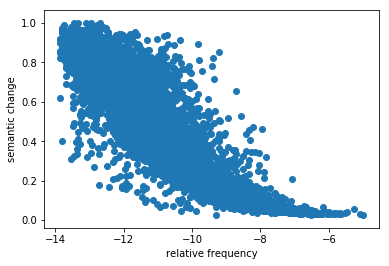

In [11]:
# Scatterplot
plt.xlabel("relative frequency")
plt.ylabel("semantic change")

plt.scatter(semantic_change_df["relative_freq"].apply(np.log),
            semantic_change_df["avg.change"]) 

## Analysis 2: Semantic Change X Polysemy

In [5]:
import statsmodels.api as sm # import statsmodels 

X = semantic_sub_df["polysemy"] 
y = semantic_sub_df["avg.change"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg.change   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2712.
Date:                Wed, 30 May 2018   Prob (F-statistic):               0.00
Time:                        09:17:04   Log-Likelihood:                 1523.3
No. Observations:               20274   AIC:                            -3043.
Df Residuals:                   20272   BIC:                            -3027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5800      0.002    272.431      0.000       0.576       0.584
polysemy      -0.0168      0.000    -52.080      0.000      -0.017      -0.016
==============================================================================
Omnibus:                     2751.122   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.398
Skew:                          -0.173   Prob(JB):                    5.13e-168
Kurtosis:                       2.110   Cond. No.                         8.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

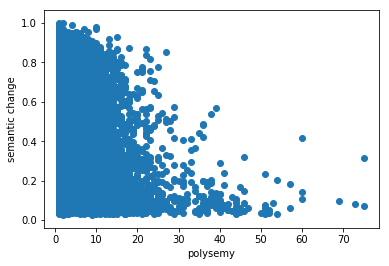

In [18]:
#Scatterplot
plt.xlabel("polysemy")
plt.ylabel("semantic change")

plt.scatter(semantic_sub_df["polysemy"],
            semantic_sub_df["avg.change"])

# Gutenberg Project

## Data Pre-Processing

In [19]:
import bs4

dataDir = '/Users/lingdai/Downloads/Gutenberg Project/'

GP_Dict = {"title":[],
           "author":[],
           "release_date":[],
           "language":[],
           "text":[]}

for Doc in ((dataDir + file) for file in os.listdir(dataDir) if file.endswith(".txt")):
    file = open(Doc, "r", encoding = "ISO-8859-1")
    DocText = file.read()
    sep_pos = DocText.find("*** START OF THE PROJECT GUTENBERG EBOOK")
    
    if sep_pos > 0:
        pre_text = DocText[:sep_pos]
        title = pre_text[pre_text.find("Title: ")+len("Title: "):].split("\n")[0]
        author = pre_text[pre_text.find("Author: ")+len("Author: "):].split("\n")[0]
        release_date = pre_text[pre_text.find("Release Date: ")+len("Release Date: "):].split("\n")[0]
        language = pre_text[pre_text.find("Language: ")+len("Language: "):].split("\n")[0]
        
        if language == 'English':
            main_text = DocText[sep_pos+1:][DocText[sep_pos+1:].find("***")+3:]
            GP_Dict['title'].append(title)
            GP_Dict['author'].append(author)
            GP_Dict['release_date'].append(release_date)
            GP_Dict['language'].append(language)
            GP_Dict['text'].append(main_text)

GPDF = pandas.DataFrame(GP_Dict)

GPDF.head()

,author,language,release_date,text,title
0,Various,English,"September, 2005 [EBook #8951]","\n\n\n\n\nProduced by Don Kretz, Juliet Suther...","Scientific American, Vol. 17, No. 26 December ..."
1,Jessie Eldridge Southwick,English,"April, 2005 [EBook #7804]","\n\n\n\n\nProduced by Charles Aldarondo, Tiffa...",Expressive Voice Culture
2,Nathaniel Hawthorne,English,"Nov, 2005 [EBook #9237]",\n\n\n\n\nThis eBook was produced by David Wid...,A Bell's Biography
3,Maria Edgeworth,English,"December, 2005 [EBook #9414]","\n\n\n\n\nProduced by Jonathan Ingram, Tapio R...","Tales and Novels, Vol. V"
4,R F Weymouth,English,"September, 2005 [EBook #8839]",\n\n\nProduced by Martin.Ward@durham.ac.uk\n\n...,"Weymouth New Testament in Modern Speech, Colos..."


In [21]:
#tokenization and removal of stopwords
GPDF['tokenized_sents'] = GPDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
GPDF['normalized_sents'] = GPDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])
GPDF.head()

,author,language,release_date,text,title,tokenized_sents,normalized_sents
0,Various,English,"September, 2005 [EBook #8951]","\n\n\n\n\nProduced by Don Kretz, Juliet Suther...","Scientific American, Vol. 17, No. 26 December ...","[[Produced, by, Don, Kretz, ,, Juliet, Sutherl...","[[produced, kretz, juliet, sutherland, distrib..."
1,Jessie Eldridge Southwick,English,"April, 2005 [EBook #7804]","\n\n\n\n\nProduced by Charles Aldarondo, Tiffa...",Expressive Voice Culture,"[[Produced, by, Charles, Aldarondo, ,, Tiffany...","[[produced, charles, aldarondo, tiffany, vergo..."
2,Nathaniel Hawthorne,English,"Nov, 2005 [EBook #9237]",\n\n\n\n\nThis eBook was produced by David Wid...,A Bell's Biography,"[[This, eBook, was, produced, by, David, Widge...","[[ebook, produced, david, widger, widger, tale..."
3,Maria Edgeworth,English,"December, 2005 [EBook #9414]","\n\n\n\n\nProduced by Jonathan Ingram, Tapio R...","Tales and Novels, Vol. V","[[Produced, by, Jonathan, Ingram, ,, Tapio, Ri...","[[produced, jonathan, ingram, tapio, riikonen,..."
4,R F Weymouth,English,"September, 2005 [EBook #8839]",\n\n\nProduced by Martin.Ward@durham.ac.uk\n\n...,"Weymouth New Testament in Modern Speech, Colos...","[[Produced, by, Martin.Ward, @, durham.ac.uk, ...","[[produced, book, colossians, paul, apostle, c..."


In [71]:
#match year for Gutenberg project documents
import re

def date_to_year(date):
    return re.findall(r"\b\d{4}\b", date)[0]

date_to_year('September, 2005 [EBook #8839]')

'2005'

In [76]:
GPDF['year'] = GPDF['text'].apply(date_to_year)
GPDF.head()

,author,language,release_date,text,title,tokenized_sents,normalized_sents,year
0,Various,English,"September, 2005 [EBook #8951]","\n\n\n\n\nProduced by Don Kretz, Juliet Suther...","Scientific American, Vol. 17, No. 26 December ...","[[Produced, by, Don, Kretz, ,, Juliet, Sutherl...","[[produced, kretz, juliet, sutherland, distrib...",1867
1,Jessie Eldridge Southwick,English,"April, 2005 [EBook #7804]","\n\n\n\n\nProduced by Charles Aldarondo, Tiffa...",Expressive Voice Culture,"[[Produced, by, Charles, Aldarondo, ,, Tiffany...","[[produced, charles, aldarondo, tiffany, vergo...",2002
2,Nathaniel Hawthorne,English,"Nov, 2005 [EBook #9237]",\n\n\n\n\nThis eBook was produced by David Wid...,A Bell's Biography,"[[This, eBook, was, produced, by, David, Widge...","[[ebook, produced, david, widger, widger, tale...",2002
3,Maria Edgeworth,English,"December, 2005 [EBook #9414]","\n\n\n\n\nProduced by Jonathan Ingram, Tapio R...","Tales and Novels, Vol. V","[[Produced, by, Jonathan, Ingram, ,, Tapio, Ri...","[[produced, jonathan, ingram, tapio, riikonen,...",1857
4,R F Weymouth,English,"September, 2005 [EBook #8839]",\n\n\nProduced by Martin.Ward@durham.ac.uk\n\n...,"Weymouth New Testament in Modern Speech, Colos...","[[Produced, by, Martin.Ward, @, durham.ac.uk, ...","[[produced, book, colossians, paul, apostle, c...",2002


In [82]:
GPDF['year'] = pd.to_numeric(GPDF['year'])
GPDF[(GPDF['year']<=2000)&(GPDF['year']>=1700)].head()

,author,language,release_date,text,title,tokenized_sents,normalized_sents,year
0,Various,English,"September, 2005 [EBook #8951]","\n\n\n\n\nProduced by Don Kretz, Juliet Suther...","Scientific American, Vol. 17, No. 26 December ...","[[Produced, by, Don, Kretz, ,, Juliet, Sutherl...","[[produced, kretz, juliet, sutherland, distrib...",1867
3,Maria Edgeworth,English,"December, 2005 [EBook #9414]","\n\n\n\n\nProduced by Jonathan Ingram, Tapio R...","Tales and Novels, Vol. V","[[Produced, by, Jonathan, Ingram, ,, Tapio, Ri...","[[produced, jonathan, ingram, tapio, riikonen,...",1857
6,Thomas A. Janvier,English,"February, 2006 [EBook #9906]","\n\n\n\n\nProduced by Juliet Sutherland, Micha...",In the Sargasso Sea,"[[Produced, by, Juliet, Sutherland, ,, Michael...","[[produced, juliet, sutherland, michael, locke...",1898
9,Various,English,"December, 2005 [EBook #9544]",\n\n\n\n\nE-text prepared by Joshua Hutchinson...,"Punchinello, Vol. 1, Issue 10","[[E-text, prepared, by, Joshua, Hutchinson, ,,...","[[prepared, joshua, hutchinson, sandra, brown,...",1870
12,John Dryden,English,"February, 2005 [EBook #7490]","\n\n\n\n\nProduced by Ted Garvin, Charles Fran...",Palamon and Arcite,"[[Produced, by, Ted, Garvin, ,, Charles, Frank...","[[produced, ted, garvin, charles, franks, dist...",1897


In [93]:
print(len(GPDF[(GPDF['year']<=1775)&(GPDF['year']>1750)]))
print(len(GPDF[(GPDF['year']<=1800)&(GPDF['year']>1775)]))
print(len(GPDF[(GPDF['year']<=1825)&(GPDF['year']>1800)]))
print(len(GPDF[(GPDF['year']<=1850)&(GPDF['year']>1825)]))
print(len(GPDF[(GPDF['year']<=1875)&(GPDF['year']>1850)]))
print(len(GPDF[(GPDF['year']<=1900)&(GPDF['year']>1875)]))
print(len(GPDF[(GPDF['year']<=1925)&(GPDF['year']>1900)]))

72
145
218
306
523
688
1016


In [23]:
#aggregate text and write to local .txt file
f = open('Gutenberg_total_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [94]:
#1750-1775
test_input = GPDF[(GPDF['year']<1775)&(GPDF['year']>=1750)]['normalized_sents'].sum()

f = open('GP_1750_1775_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [95]:
#1775-1800
test_input = GPDF[(GPDF['year']<1800)&(GPDF['year']>=1775)]['normalized_sents'].sum()

f = open('GP_1775_1800_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [96]:
#1800-1825
test_input = GPDF[(GPDF['year']<1825)&(GPDF['year']>=1800)]['normalized_sents'].sum()

f = open('GP_1800_1825_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [97]:
#1825-1850
test_input = GPDF[(GPDF['year']<1850)&(GPDF['year']>=1825)]['normalized_sents'].sum()

f = open('GP_1825_1850_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [98]:
#1850-1875
test_input = GPDF[(GPDF['year']<1875)&(GPDF['year']>=1850)]['normalized_sents'].sum()

f = open('GP_1850_1875_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [99]:
#1875-1900
test_input = GPDF[(GPDF['year']<1900)&(GPDF['year']>=1875)]['normalized_sents'].sum()

f = open('GP_1875_1900_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

In [100]:
#1900-1925
test_input = GPDF[(GPDF['year']<1925)&(GPDF['year']>=1900)]['normalized_sents'].sum()

f = open('GP_1900_1925_text.txt','w')

for sent in test_input:
    if len(sent) > 0:
        line = ""
        for word in sent[:-1]:
            line += (word + ", ")
        line += sent[-1]
        f.write(line+"\n")
        
f.close()

## Load MapReduce Total Count Results

In [ ]:
#gutenberg project total count
gp_count_df = pandas.read_csv("GP_total_count.txt", delim_whitespace=True,
                              header=None, names = ["word", "count"])

gp_count_df = gp_count_df.sort_values(by = ["count"], axis = 0, ascending = False)
gp_count_df.head()

In [28]:
#write top 1000 frequent vocabularies to txt file (reference frame for collocation)
f = open('GP_top_1000_words.txt','w')

for w in gp_count_df['word'][:1000]:
    f.write(w+"\n")
        
f.close()

## Load MapReduce Collocation Results

In [4]:
GP_1750_1775_colloc = pd.read_csv("GP_1750_1775_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])

GP_1750_1775_colloc['vec'] = GP_1750_1775_colloc['vec'].apply(json.loads)
GP_1750_1775_colloc.head()

,word,vec
0,lacs,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,lactantius,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,lacte,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,lactea,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,lactilla,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, ..."


In [5]:
GP_1775_1800_colloc = pd.read_csv("GP_1775_1800_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])

GP_1775_1800_colloc['vec'] = GP_1775_1800_colloc['vec'].apply(json.loads)
GP_1775_1800_colloc.head()

,word,vec
0,kowno,"[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,kowrowa,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,kr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,kr\u00f6yer,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,kr\u00fcdener,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [6]:
GP_1800_1825_colloc = pd.read_csv("GP_1800_1825_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])

GP_1800_1825_colloc['vec'] = GP_1800_1825_colloc['vec'].apply(json.loads)
GP_1800_1825_colloc.head()

,word,vec
0,lachrymals,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,lachrymas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,lachrymation,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,lachrymatory,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,lachrymose,"[0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."


In [7]:
GP_1825_1850_colloc = pd.read_csv("GP_1825_1850_colloc.txt", delimiter = "	",
                               header=None, names = ['word','vec'])

GP_1825_1850_colloc['vec'] = GP_1825_1850_colloc['vec'].apply(json.loads)
GP_1825_1850_colloc.head()

,word,vec
0,label,"[0.13513513513513514, 0.05405405405405406, 0.0..."
1,labeled,"[0.0, 0.0, 0.14285714285714285, 0.142857142857..."
2,labeling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,labelle,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,labelled,"[0.1875, 0.0, 0.09375, 0.15625, 0.03125, 0.0, ..."


In [51]:
#find common vocabularies
common_vocabs = list(set(GP_1825_1850_colloc['word'].tolist() + 
                         GP_1800_1825_colloc['word'].tolist() +
                         GP_1775_1800_colloc['word'].tolist() +
                         GP_1750_1775_colloc['word'].tolist()))
len(common_vocabs)

212476

In [75]:
# remove some low-frequency vocabularies
commonvocabs = sorted(list(set(common_vocabs[1:])&set(gp_count_df[gp_count_df['count']>=500]['word'].tolist())))
len(commonvocabs)

22631

## Compute Semantic Change

In [85]:
import scipy

def compute_semantic_change(word, df1, df2):
    vec1 = df1[df1['word']==word]['vec'].sum()
    vec2 = df2[df2['word']==word]['vec'].sum()
    return scipy.spatial.distance.cosine(vec1,vec2)

compute_semantic_change('love', GP_1825_1850_colloc, GP_1800_1825_colloc)

0.017574487287371876

In [87]:
semantic_change_1775 = []
semantic_change_1800 = []
semantic_change_1825 = []


for word in commonvocabs:
    semantic_change_1775.append(compute_semantic_change(word,
                                                        GP_1750_1775_colloc,
                                                        GP_1775_1800_colloc))
    semantic_change_1800.append(compute_semantic_change(word,
                                                        GP_1775_1800_colloc,
                                                        GP_1800_1825_colloc))
    semantic_change_1825.append(compute_semantic_change(word,
                                                        GP_1800_1825_colloc,
                                                        GP_1825_1850_colloc))

/Users/lingdai/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
gp_semantic_change = pandas.DataFrame({"word":commonvocabs,
                                       "change_1775":semantic_change_1775,
                                       "change_1800":semantic_change_1800,
                                       "change_1825":semantic_change_1825})

gp_semantic_change['avg.change'] = (gp_semantic_change['change_1775'] +
                                    gp_semantic_change['change_1800'] +
                                    gp_semantic_change['change_1825'])/3

gp_semantic_change = gp_semantic_change[['word','avg.change',
                                         'change_1775','change_1800','change_1825']]

gp_semantic_change = gp_semantic_change.sort_values(by=['avg.change'],ascending = True)
gp_semantic_change.head()

In [90]:
gp_semantic_change = gp_semantic_change.dropna()
len(gp_semantic_change)

21306

## Compute Relative Frequency

In [96]:
def gp_match_count(vocab):
    if gp_count_df[gp_count_df['word']==vocab]['count'].tolist():
        return gp_count_df[gp_count_df['word']==vocab]['count'].tolist()[0]
    return 0

gp_match_count("language")

40451

In [97]:
gp_semantic_change['count'] = gp_semantic_change['word'].apply(gp_match_count)
gp_semantic_change.head()

,word,avg.change,change_1775,change_1800,change_1825,count
8395,ftp,0.0,0.0,0.0,0.0,4792
12717,merchantability,0.0,0.0,0.0,0.0,4783
15171,pmb,0.0,0.0,0.0,0.0,4099
7798,filename,0.0,0.0,0.0,0.0,4854
6102,donate,0.0,0.0,0.0,0.0,9603


In [98]:
total_count = gp_semantic_change['count'].sum()
gp_semantic_change['relative_freq'] = gp_semantic_change['count']/total_count
gp_semantic_change[:10]

,word,avg.change,change_1775,change_1800,change_1825,count,relative_freq
8395,ftp,0.000000e+00,0.0,0.0,0.000000,4792,0.000031
12717,merchantability,0.000000e+00,0.0,0.0,0.000000,4783,0.000031
15171,pmb,0.000000e+00,0.0,0.0,0.000000,4099,0.000026
7798,filename,0.000000e+00,0.0,0.0,0.000000,4854,0.000031
6102,donate,0.000000e+00,0.0,0.0,0.000000,9603,0.000062
3091,cataloguers,0.000000e+00,0.0,0.0,0.000000,4787,0.000031
13552,newsletter,0.000000e+00,0.0,0.0,0.000000,9593,0.000062
21929,warranties,0.000000e+00,0.0,0.0,0.000000,14358,0.000092
13553,newsletters,0.000000e+00,0.0,0.0,0.000000,4790,0.000031
660,alternatively,3.909977e-07,0.0,0.0,0.000001,9603,0.000062


## Analysis 1: Semantic Change X Relative Frequency

In [99]:
import statsmodels.api as sm # import statsmodels 

X = gp_semantic_change["relative_freq"] 
y = gp_semantic_change["avg.change"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg.change   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     3433.
Date:                Sun, 03 Jun 2018   Prob (F-statistic):               0.00
Time:                        10:57:10   Log-Likelihood:                 1863.0
No. Observations:               21306   AIC:                            -3722.
Df Residuals:                   21304   BIC:                            -3706.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5250      0.002    333.738      0.000       0.522       0.528
relative_freq  -511.2515      8.726    -58.592      0.000    -528.354    -494.149
==============================================================================
Omnibus:                     2107.572   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12353.264
Skew:                           0.292   Prob(JB):                         0.00
Kurtosis:                       6.684   Cond. No.                     5.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

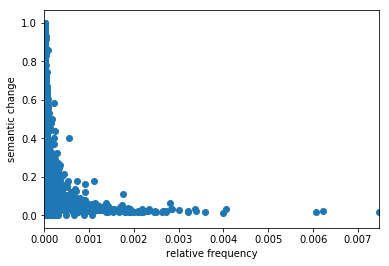

In [103]:
plt.xlabel("relative frequency")
plt.ylabel("semantic change")
plt.xlim(0, gp_semantic_change["relative_freq"].max())

plt.scatter(gp_semantic_change["relative_freq"],
            gp_semantic_change["avg.change"])

In [118]:
import statsmodels.api as sm # import statsmodels 

X = gp_semantic_change["relative_freq"].apply(np.log) 
y = gp_semantic_change["avg.change"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg.change   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 6.661e+04
Date:                Sun, 03 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:16:28   Log-Likelihood:                 15372.
No. Observations:               21306   AIC:                        -3.074e+04
Df Residuals:                   21304   BIC:                        -3.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3646      0.007   -187.617      0.000      -1.379      -1.350
relative_freq    -0.1680      0.001   -258.096      0.000      -0.169      -0.167
==============================================================================
Omnibus:                     1352.165   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2793.023
Skew:                           0.437   Prob(JB):                         0.00
Kurtosis:                       4.543   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

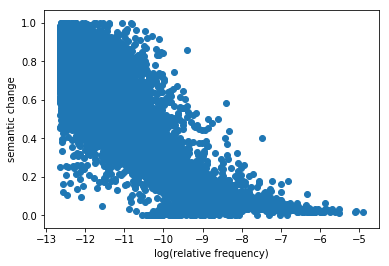

In [105]:
plt.xlabel("log(relative frequency)")
plt.ylabel("semantic change")

plt.scatter(gp_semantic_change["relative_freq"].apply(np.log),
            gp_semantic_change["avg.change"])

## Compute Polysemy

In [111]:
def gp_count_meaning(word):
    m = 0
    meanings_dict = semantic_change_df[semantic_change_df['word']==word]['polysemy'].tolist()
    if meanings_dict:
        m = meanings_dict[0]
    else:
        meanings_dict = PyDictionary().meaning(word)
        if meanings_dict:
            for key in meanings_dict:
                m += len(meanings_dict[key])
    return m

count_meaning('love')

10

In [ ]:
gp_semantic_change['polysemy'] = gp_semantic_change['word'].apply(gp_count_meaning)

In [113]:
pd_semantic_change.head()

,word,avg.change,change_1775,change_1800,change_1825,count,relative_freq,polysemy
8395,ftp,0.0,0.0,0.0,0.0,4792,0.000031,2
12717,merchantability,0.0,0.0,0.0,0.0,4783,0.000031,1
15171,pmb,0.0,0.0,0.0,0.0,4099,0.000026,0
7798,filename,0.0,0.0,0.0,0.0,4854,0.000031,1
6102,donate,0.0,0.0,0.0,0.0,9603,0.000062,1


In [116]:
import statsmodels.api as sm # import statsmodels 

X = gp_semantic_change["polysemy"]
y = gp_semantic_change["avg.change"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg.change   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     2950.
Date:                Sun, 03 Jun 2018   Prob (F-statistic):               0.00
Time:                        12:02:33   Log-Likelihood:                 1652.8
No. Observations:               21306   AIC:                            -3302.
Df Residuals:                   21304   BIC:                            -3286.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5737      0.002    281.871      0.000       0.570       0.578
polysemy      -0.0171      0.000    -54.311      0.000      -0.018      -0.016
==============================================================================
Omnibus:                     1153.415   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.534
Skew:                          -0.257   Prob(JB):                    1.09e-135
Kurtosis:                       2.340   Cond. No.                         8.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

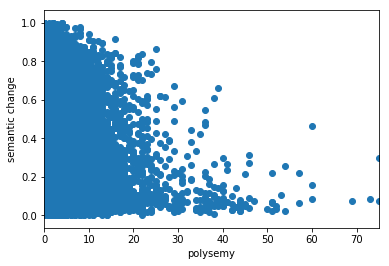

In [115]:
#Scatterplot
plt.xlabel("polysemy")
plt.ylabel("semantic change")
plt.xlim(0, gp_semantic_change["polysemy"].max())

plt.scatter(gp_semantic_change["polysemy"],
            gp_semantic_change["avg.change"])